In [1]:
# 1. Install required packages
!pip install datasets
!pip install unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 23.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# 2. Load Unsloth and environment setup
from unsloth import FastLanguageModel, is_bfloat16_supported
from datasets import load_dataset, load_from_disk
from transformers import TrainingArguments
from trl import SFTTrainer
import torch
import os

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
# 3. Load the quantized Mistral 7B model with LoRA
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-bnb-4bit",  # Unsloth's quantized Mistral 7B
    max_seq_length = 2048,
    dtype = torch.float16,
    load_in_4bit = True,
)

==((====))==  Unsloth 2025.3.19: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    NVIDIA H100 PCIe. Num GPUs = 1. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

In [4]:
#4. load dataset
# Load dataset from Hugging Face
dataset = load_dataset("hakurei/open-instruct-v1", split="train")

README.md:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

instruct_data.json:   0%|          | 0.00/104M [00:00<?, ?B/s]

additional_data.json:   0%|          | 0.00/19.7M [00:00<?, ?B/s]

alpaca_data.json:   0%|          | 0.00/22.7M [00:00<?, ?B/s]

gpt4_data.json:   0%|          | 0.00/12.2M [00:00<?, ?B/s]

roleplay_instruct.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

self_instruct.json:   0%|          | 0.00/26.2M [00:00<?, ?B/s]

sharegpt_data.json:   0%|          | 0.00/109M [00:00<?, ?B/s]

synthetic_instruct.json:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/498813 [00:00<?, ? examples/s]

In [5]:
#5. Format dataset
# Format into <s>[INST] prompt [/INST] output</s>

def formatting_func(example):
    prompt = f"<s>[INST] {example['instruction']} [/INST] {example['output']}</s>"
    
    return {"text": prompt}
 
dataset = dataset.map(formatting_func, remove_columns=dataset.column_names)

 

Map:   0%|          | 0/498813 [00:00<?, ? examples/s]

In [6]:
# Tokenize and save
dataset = dataset.map(
    lambda samples: tokenizer(samples["text"], truncation=True, padding=False, max_length=2048),
    batched=True,
    num_proc=4,
)
dataset.save_to_disk("tokenized_openinstruct")
print("✅ Tokenized dataset saved!")

Map (num_proc=4):   0%|          | 0/498813 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/498813 [00:00<?, ? examples/s]

✅ Tokenized dataset saved!


In [7]:
# Set format for Trainer compatibility
dataset.set_format(type="torch")

In [8]:
# 6. Prepare model for training
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = True,
    random_state = 42,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2025.3.19 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [9]:
# 7. Training setup
bf16 = is_bfloat16_supported()
 
trainer = SFTTrainer(
    model = model,
    train_dataset = dataset,
    tokenizer = tokenizer,
    dataset_text_field = "text",
    max_seq_length = 2048,
    packing = False,
    args = TrainingArguments(
        output_dir = "./mistral-prosense-clean",
        per_device_train_batch_size = 16,
        gradient_accumulation_steps = 2,
        warmup_steps = 5,
        num_train_epochs = 1,
        learning_rate = 2e-4,
        fp16 = True,
        bf16 = False,
        logging_steps = 1,
        save_strategy="steps",
        save_steps=1000,
        save_total_limit=2,
        resume_from_checkpoint=True,
        gradient_checkpointing = True,
        optim = "adamw_8bit",
        lr_scheduler_type = "cosine",
    ),
)
 

In [10]:
# 8. Train
trainer.train()
 
# 9. Save model and tokenizer
model.save_pretrained("./mistral-prosense-final")
tokenizer.save_pretrained("./mistral-prosense-final")

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 498,813 | Num Epochs = 1 | Total steps = 15,588
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 2 x 1) = 32
 "-____-"     Trainable parameters = 41,943,040/7,000,000,000 (0.60% trained)
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.168200
2,1.531800
3,2.068100
4,1.736700
5,1.918500
6,1.224900
7,1.555700
8,1.435500
9,1.510700
10,1.603000


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or

('./mistral-prosense-final/tokenizer_config.json',
 './mistral-prosense-final/special_tokens_map.json',
 './mistral-prosense-final/tokenizer.model',
 './mistral-prosense-final/added_tokens.json',
 './mistral-prosense-final/tokenizer.json')

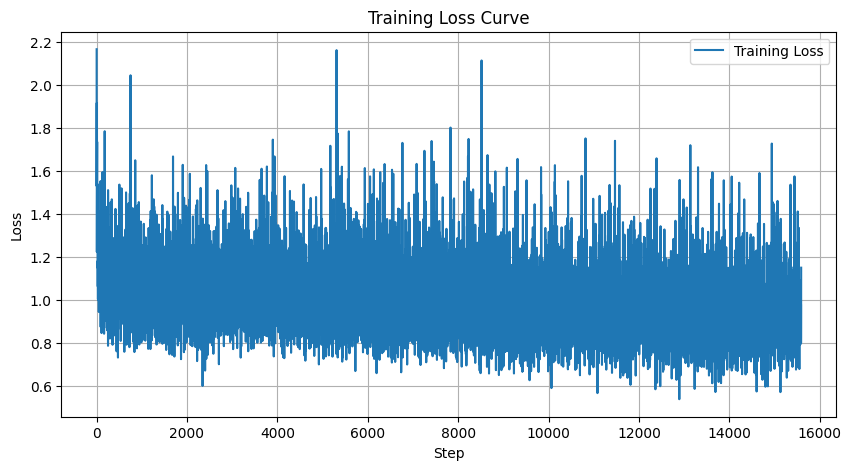

In [14]:
import json

import matplotlib.pyplot as plt
 
log_file_path = "./mistral-prosense-clean/checkpoint-15588/trainer_state.json"
 
with open(log_file_path, "r") as f:

    logs = json.load(f)
 
losses = [log["loss"] for log in logs["log_history"] if "loss" in log]

steps = [log["step"] for log in logs["log_history"] if "loss" in log]
 
plt.figure(figsize=(10, 5))

plt.plot(steps, losses, label="Training Loss")

plt.xlabel("Step")

plt.ylabel("Loss")

plt.title("Training Loss Curve")

plt.legend()

plt.grid()

plt.show()

 

In [12]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 234.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 224.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 202.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
